In this notebook, we continue to study the track of hedging in the world of FX options still from a trader sitting in a exotic desk in the S&T branch of a bank. As we've seen in the previous notebook ([Hedging a book of exotics options](exotic-book.ipynb)) we have cover the basics on how to hedge a book of FX exotics, in this notebook we are going to take a further step to what is used in practice since, as you might know volatilities in practice are not flat across different strikes and across different time to expirations. Thus we are going to introduce a method that is going to take into account also for those volatilities as well to produce market consistent prices. This method is called the **Vanna-Volga** method.  

Again as a library we are going to use `QuantLib`, because, well why not, right?

In [1]:
from enum import Enum
from functools import partial
from dataclasses import dataclass
from typing import Callable, List, Union

import numpy as np
import matplotlib.pyplot as plt
import QuantLib as ql

In [2]:
class FxVanillaOptionFactory:
    """
    Helper class used to create Vanilla FX Options and related objects used to price those
    """

    def __init__(self, spot: ql.QuoteHandle, expiry: ql.Date, option_type: ql.Option):
        self.exercise_ = ql.EuropeanExercise(expiry)
        self.option_type_ = option_type
        self.spot_ = spot
    
    def get_option(self, strike: float) -> ql.VanillaOption:
        payoff = ql.PlainVanillaPayoff(self.option_type_, strike)
        return ql.VanillaOption(payoff, self.exercise_)
    
    def get_gk_process(self, 
                       domesitc_ts_handle: ql.YieldTermStructureHandle, 
                       foreign_ts_handle: ql.YieldTermStructureHandle, 
                       vol_ts_handle: ql.BlackVolTermStructureHandle):
        """
        Construct and return a QuantLib Garman-Kohlhagen process for FX option pricing.

        Parameters:
            domesitc_ts_handle (ql.YieldTermStructureHandle): The yield term structure handle for the domestic (quote) currency.
            foreign_ts_handle (ql.YieldTermStructureHandle): The yield term structure handle for the foreign (base) currency.
            vol_ts_handle (ql.BlackVolTermStructureHandle): The Black volatility term structure handle for the FX rate.

        Returns:
            ql.GarmanKohlagenProcess: The stochastic process object used for pricing FX options under the Garman-Kohlhagen model.
        """
        return ql.GarmanKohlagenProcess(
            self.spot_,
            foreign_ts_handle,
            domesitc_ts_handle,
            vol_ts_handle
        )
    
    @staticmethod
    def assign_analyitcal_price_engine(option: ql.Option, process: ql.StochasticProcess):
        engine = ql.AnalyticEuropeanEngine(process)
        option.setPricingEngine(engine)

In [3]:
class FxBarrierOptionFactory:
    """
    Helper class used to create Vanilla FX Options and related objects used to price those
    """

    def __init__(self, spot: ql.QuoteHandle, option_type: ql.Option):
        self.option_type_ = option_type
        self.spot_ = spot
    
    def get_option(self, strike: float, exercise: ql.Exercise, barrier: float, barrier_t: ql.Barrier) -> ql.BarrierOption:
        payoff = ql.PlainVanillaPayoff(self.option_type_, strike)
        return ql.BarrierOption(barrier_t, barrier, 0.0, payoff, exercise)
    
    def get_gk_process(self,
                       domesitc_ts_handle: ql.YieldTermStructureHandle, 
                       foreign_ts_handle: ql.YieldTermStructureHandle, 
                       vol_ts_handle: ql.BlackVolTermStructureHandle):
        """
        Construct and return a QuantLib Garman-Kohlhagen process for FX option pricing.

        Parameters:
            domesitc_ts_handle (ql.YieldTermStructureHandle): The yield term structure handle for the domestic (quote) currency.
            foreign_ts_handle (ql.YieldTermStructureHandle): The yield term structure handle for the foreign (base) currency.
            vol_ts_handle (ql.BlackVolTermStructureHandle): The Black volatility term structure handle for the FX rate.

        Returns:
            ql.GarmanKohlagenProcess: The stochastic process object used for pricing FX options under the Garman-Kohlhagen model.
        """
        return ql.GarmanKohlagenProcess(
            self.spot_,
            foreign_ts_handle,
            domesitc_ts_handle,
            vol_ts_handle
        )
    
    @staticmethod
    def assign_analyitcal_price_engine(option: ql.Option, process: ql.StochasticProcess):
        engine = ql.AnalyticBarrierEngine(process)
        option.setPricingEngine(engine)

    @staticmethod
    def assign_price_engine(option: ql.Option, engine: ql.PricingEngine):
        option.setPricingEngine(engine)

    @staticmethod
    def assign_vanna_volga_price_engine(
            option: ql.Option, 
            atm_dvol_handle: ql.DeltaVolQuoteHandle, 
            delta25_p_dvol_handle,
            delta25_c_dvol_handle,
            spot_handle: ql.QuoteHandle,
            usd_disc_ts: ql.YieldTermStructureHandle,
            eur_disc_ts: ql.YieldTermStructureHandle
        ):
        engine = ql.VannaVolgaBarrierEngine(
            atm_dvol_handle,
            delta25_p_dvol_handle, 
            delta25_c_dvol_handle, 
            spot_handle,
            usd_disc_ts,
            eur_disc_ts
        )
        option.setPricingEngine(engine)

In [4]:
class SpotFX(ql.Instrument):

    def __init__(self, spot_quote: ql.Quote):
        self._spot_quote = spot_quote

    def NPV(self) -> float:
        return self._spot_quote.value()
    

class NullInstrument(ql.Instrument):

    def __init__(self):
        pass

    def NPV(self) -> float:
        return 0.0


@dataclass
class Position:
    instrument: ql.Instrument
    notional: float

    def NPV(self) -> float:
        return self.instrument.NPV() * self.notional
    
    def raw_sensitivity(self, greek_fn: Callable, **kwargs) -> float:
        h = kwargs.get("h")
        k = kwargs.get("k")

        if k:
            return greek_fn(self.instrument, h=h, k=k)
        else:
            return greek_fn(self.instrument, h=h)

    def sensitivity(self, greek_fn: Callable, **kwargs) -> float:
        greek_value = self.raw_sensitivity(greek_fn, **kwargs)

        return greek_value * self.notional
    
class BarrierPosition(Position):

    def __init__(self, instrument: ql.Instrument, notional: float, backup_instrument: Union[ql.Instrument, NullInstrument]):
        super().__init__(instrument, notional)
        self._backup_instrument = backup_instrument

    def NPV(self) -> float:
        try:
            npv = super().NPV()
        except RuntimeError:
            npv = self._backup_instrument.NPV()

        return npv
    
    def raw_sensitivity(self, greek_fn: Callable, **kwargs) -> float:
        try:
            greek_val = super().raw_sensitivity(greek_fn, **kwargs)
        except RuntimeError:
            h = kwargs.get("h")
            k = kwargs.get("k")

            if k:
                greek_val = greek_fn(self._backup_instrument, h=h, k=k)
            else:
                greek_val = greek_fn(self._backup_instrument, h=h)

        return greek_val
    
@dataclass
class CompositePosition:
    instruments: List[ql.Instrument]
    notional: float

    def NPV(self) -> float:
        return sum([i.NPV() for i in self.instruments]) * self.notional
    
    def raw_sensitivity(self, greek_fn: Callable, **kwargs) -> float:
        h = kwargs.get("h")
        k = kwargs.get("k")

        if k:
            return sum([greek_fn(i, h=h, k=k) for i in self.instruments])
        else:
            return sum([greek_fn(i, h=h) for i in self.instruments])

    def sensitivity(self, greek_fn: Callable, **kwargs) -> float:
        greek_value = self.raw_sensitivity(greek_fn, **kwargs)

        return greek_value * self.notional
    
@dataclass
class WeightedCompositePosition:
    instruments: List[ql.Instrument]
    notionals: List[float]

    def NPV(self) -> float:
        return sum([i.NPV() * n for i, n in zip(self.instruments, self.notionals)])
    
    def raw_sensitivity(self, greek_fn: Callable, **kwargs) -> float:
        h = kwargs.get("h")
        k = kwargs.get("k")
        total_n = sum(self.notionals)

        if k:
            return sum([greek_fn(i, h=h, k=k) * n / total_n for i, n in zip(self.instruments, self.notionals)])
        else:
            return sum([greek_fn(i, h=h) * n / total_n for i, n in zip(self.instruments, self.notionals)])

    def sensitivity(self, greek_fn: Callable, **kwargs) -> float:
        greek_value = self.raw_sensitivity(greek_fn, **kwargs)
        total_n = sum(self.notionals)

        return greek_value * total_n


In [5]:
def create_const_vol_handle(ref_date: ql.Date, vol_handle: ql.QuoteHandle, dc: ql.DayCounter):
    black_vol = ql.BlackConstantVol(ref_date, ql.NullCalendar(), vol_handle, dc)
    vol_ts_handle = ql.BlackVolTermStructureHandle(black_vol)
    return vol_ts_handle

## Market Data

Let's assume that we are an USD based desk and we are dealing with EURUSD exotics. The initial market data at time $t = 0$ is the following

$$
\begin{align*}
    S_0 &= 1.18 \\
    Date(Today) &= 16/09/2025 \\
    T &= 0.5 \text{ (time to expiration in years)} \\
    r_d &= 0.045 \\
    r_f &= 0.02 \\
    \sigma &= 0.13 \\
\end{align*}
$$

Let's further assume that in our book we have all options expirying in 6 months (thus $T = 0.5$).

In [ ]:
#| echo: true

EUR_USD = 1.18
spot_quote = ql.SimpleQuote(EUR_USD)
today = ql.Date(16, ql.September, 2025)
ref_date = today
r_d = 0.045
r_f = 0.02
vol_quote = ql.SimpleQuote(0.13)
spot_handle = ql.QuoteHandle(spot_quote)
vol_handle = ql.QuoteHandle(vol_quote)

dc = ql.Actual365Fixed()
calendar = ql.JointCalendar(ql.Italy(), ql.UnitedStates(ql.UnitedStates.NYSE))

expiration_date = ref_date + ql.Period(6, ql.Months)
expiration_time = dc.yearFraction(ref_date, expiration_date)
domestic_rf_handle = ql.YieldTermStructureHandle(ql.FlatForward(today, r_d, dc))
foreign_rf_handle = ql.YieldTermStructureHandle(ql.FlatForward(today, r_f, dc))
black_vol = ql.BlackConstantVol(today, ql.NullCalendar(), vol_handle, dc)
vol_ts_handle = ql.BlackVolTermStructureHandle(black_vol)

exp_time_quote = ql.SimpleQuote(expiration_time)
exp_time_handle = ql.QuoteHandle(exp_time_quote)
exp_time_sqrt_quote = ql.DerivedQuote(exp_time_handle, function=lambda x: np.sqrt(x))
exp_time_sqrt_handle = ql.QuoteHandle(exp_time_sqrt_quote)

delta_type = ql.DeltaVolQuote.Spot
atm_type = ql.DeltaVolQuote.AtmSpot
atm_vol, delta25_call_vol, delta25_put_vol = 0.11, 0.125, 0.14
atm_vol_quote = ql.SimpleQuote(atm_vol)
delta25_call_vol_quote = ql.SimpleQuote(delta25_call_vol)
delta25_put_vol_quote = ql.SimpleQuote(delta25_put_vol)


# Handle creations
spot_handle = ql.QuoteHandle(spot_quote)
atm_vol_handle = ql.QuoteHandle(atm_vol_quote)
delta25_c_vol_handle = ql.QuoteHandle(delta25_call_vol_quote)
delta25_p_vol_handle = ql.QuoteHandle(delta25_put_vol_quote)

atm_dvol_quote = ql.DeltaVolQuote(atm_vol_handle, delta_type, expiration_time, atm_type)
delta25_c_dvol_quote = ql.DeltaVolQuote(0.25, delta25_c_vol_handle, expiration_time, delta_type)
delta25_p_dvol_quote = ql.DeltaVolQuote(-0.25, delta25_p_vol_handle, expiration_time, delta_type)
atm_dvol_handle = ql.DeltaVolQuoteHandle(atm_dvol_quote)
delta25_c_dvol_handle = ql.DeltaVolQuoteHandle(delta25_c_dvol_quote)
delta25_p_dvol_handle = ql.DeltaVolQuoteHandle(delta25_p_dvol_quote)

atm_std_handle = ql.QuoteHandle(ql.CompositeQuote(atm_vol_handle, exp_time_sqrt_handle, lambda x, y: x * y))
delta25_c_std_handle = ql.QuoteHandle(ql.CompositeQuote(delta25_c_vol_handle, exp_time_sqrt_handle, lambda x, y: x * y))
delta25_p_std_handle = ql.QuoteHandle(ql.CompositeQuote(delta25_p_vol_handle, exp_time_sqrt_handle, lambda x, y: x * y))

# Setting the global evaluation date
ql.Settings.instance().evaluationDate = today

In [ ]:
#| echo: true

eur_dates = [ql.Date(27, ql.August, 2025), ql.Date(27, ql.August, 2026), ql.Date(27, ql.August, 2027)]
eur_dfs = [1.0, 0.98, 0.95]
eur_curve = ql.DiscountCurve(eur_dates, eur_dfs, dc)
eur_curve.enableExtrapolation()
eur_disc_ts = ql.YieldTermStructureHandle(eur_curve)

usd_dates = [ql.Date(27, ql.August, 2025), ql.Date(27, ql.August, 2026), ql.Date(27, ql.August, 2027)]
usd_dfs = [1.0, 0.985, 0.96]
usd_curve = ql.DiscountCurve(usd_dates, usd_dfs, dc)
usd_curve.enableExtrapolation()
usd_disc_ts = ql.YieldTermStructureHandle(usd_curve)

We know, from empirical experience, that the volatilities across a specific time to expiration are not the same for all the strikes, this is due a number of different reasons: market demand dynamics, skewness of returns, the presence of jumps, ...

Thus let's define the smile for the barrier options expiring in 6 months, assuming that we know the values of the vols for the ATM, 25 $\Delta$ puts, and 25 $\Delta$ calls. To do that, QuantLib come in handy with ready classes to define a smile across different strikes with a fixed tenor. 

The [SmileSection class](https://quantlib-python-docs.readthedocs.io/en/latest/termstructures.html#smilesections), is an object provided by the QuantLib library that represent a volatility smile for a specific tenor. QuantLib export some subclasses of ``SmileSection`` using different interpolation methods, thus you can choose some of them according to you needs.

In [ ]:
#| echo: true

call_barrier_factory = FxBarrierOptionFactory(spot_handle, ql.Option.Call)
put_barrier_factory = FxBarrierOptionFactory(spot_handle, ql.Option.Put)
put_vanilla_factory = FxVanillaOptionFactory(spot_handle, expiration_date, ql.Option.Put)
call_vanilla_factory = FxVanillaOptionFactory(spot_handle, expiration_date, ql.Option.Call)
delta_call_calc = ql.BlackDeltaCalculator(
    ql.Option.Call, 
    ql.DeltaVolQuote.Spot, 
    EUR_USD, 
    eur_curve.discount(expiration_time), 
    usd_curve.discount(expiration_time), 
    np.sqrt(black_vol.blackVariance(expiration_time, EUR_USD)))
delta_put_calc = ql.BlackDeltaCalculator(
    ql.Option.Put, 
    ql.DeltaVolQuote.Spot, 
    EUR_USD, 
    eur_curve.discount(expiration_time), 
    usd_curve.discount(expiration_time), 
    np.sqrt(black_vol.blackVariance(expiration_time, EUR_USD)))

# Get the strikes equivalent for the 0.25 delta for call and put options
d25_call_strike = delta_call_calc.strikeFromDelta(0.25)
d25_put_strike = delta_put_calc.strikeFromDelta(-0.25)
atm_strike = delta_call_calc.atmStrike(ql.DeltaVolQuote.AtmDeltaNeutral)

In [ ]:
#| echo: true

# Define the smile using a Spline Cubic interpolation
smile = ql.SplineCubicInterpolatedSmileSection(
    expiration_time, 
    [d25_put_strike, atm_strike, d25_call_strike],
    [delta25_p_std_handle, atm_std_handle, delta25_c_std_handle],
    ql.makeQuoteHandle(atm_strike)
)

def get_smile_vols(smile: ql.SmileSection, strikes: Union[np.array, List[float]]) -> List[float]:
    return [smile.volatility(s) for s in strikes]

In [ ]:
#| echo: true

strikes = np.arange(d25_put_strike - 0.01, d25_call_strike + 0.04, 0.01)
smile_vols = get_smile_vols(smile, strikes)

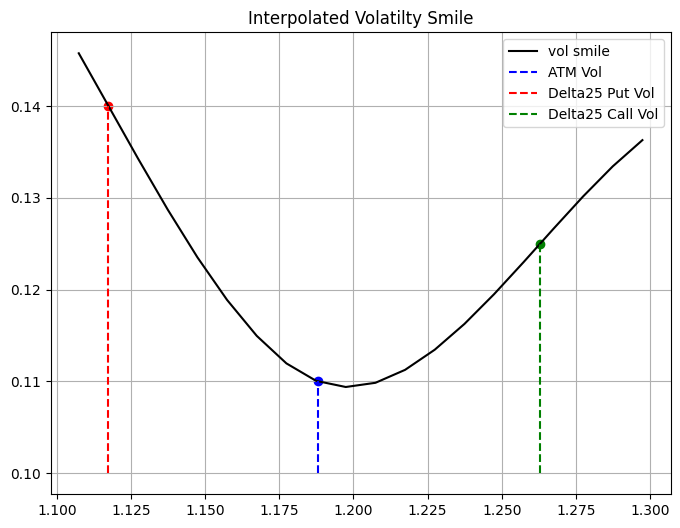

In [ ]:
ax, fig = plt.subplots(1, 1, figsize=(8, 6))

plt.plot(strikes, smile_vols, 'black', label='vol smile')

plt.vlines(atm_strike, 0.10, atm_vol, color='blue', linestyle='--', label='ATM Vol')
plt.scatter(atm_strike, atm_vol, color='blue', marker='o') # Mark the point

plt.vlines(d25_put_strike, 0.10, delta25_put_vol, color='red', linestyle='--', label='Delta25 Put Vol')
plt.scatter(d25_put_strike, delta25_put_vol, color='red', marker='o') # Mark the point

plt.vlines(d25_call_strike, 0.10, delta25_call_vol, color='green', linestyle='--', label='Delta25 Call Vol')
plt.scatter(d25_call_strike, delta25_call_vol, color='green', marker='o') # Mark the point

plt.title('Interpolated Volatilty Smile')
plt.legend()
plt.grid()
plt.show()

As mentioned above, the pricing method used in this notebook resembles what is acctually used in real life to be consistent with market prices. To take into account also for the smile a pricing method has been developed by Castagna and Mercurio [see @vv-article]. 

The **Vanna-Volga** method takes into account the volatility smile when pricing FX options by adjusting the BS price. It is based on the construction of a locally replicating portfolio whose associate hedging costs are added to the corresponding BS price so as to produce smile-consisent values. 

Assume that we construct our hedging portfolio with the following options: 25 $\Delta$ put, ATM call and 25 $\Delta$ call where the strikes are denoted by $K_i, i = 1, 2, 3 \text{ and } K_1 < K_2 < K_3$ and market implied volatilities are denoted by $\sigma_i, i = 1, 2, 3$. Using these options we can build a portfolio that zeros the partial derivatives up to the second order. In fact, denoting respectively by $\Delta_t$ and $x_i$ the units of underlying assets and options with strikes $K_i$ held at time $t$ and selling $C_i^{BS}(t) = C^{BS}(t, K_i)$ under diffusion dynamics both for $S_t$ and $\sigma = \sigma_t$, we have by Ito's Lemma:

$$
\begin{align*}
d C^{BS}(t, K) - \Delta_t d S_t - \sum_{i = 1}^3 x_i d C_i^{BS}(t)  & = [ \frac{\partial C^{BS}(t; K)}{\partial t} - \sum x_i \frac{\partial C_{i}^{BS}(t)}{\partial t} ] dt + [ \frac{\partial C^{BS}(t; K)}{\partial S} - \Delta_t - \sum x_i \frac{\partial C_{i}^{BS}(t)}{\partial S} ] dS \\
& + [ \frac{\partial C^{BS}(t; K)}{\partial \sigma} - \sum x_i \frac{\partial C_{i}^{BS}(t)}{\partial \sigma} ] d \sigma_t + \frac{1}{2} [ \frac{\partial^2 C^{BS}(t; K)}{\partial S^2} - \sum x_i \frac{\partial^2 C_{i}^{BS}(t)}{\partial S^2} ] (d S)^2 \\
& + \frac{1}{2} [ \frac{\partial^2 C^{BS}(t; K)}{\partial \sigma^2} - \sum x_i \frac{\partial^2 C_{i}^{BS}(t)}{\partial \sigma^2} ] (d \sigma)^2 + [ \frac{\partial^2 C^{BS}(t; K)}{\partial S \partial \sigma } - \sum x_i \frac{\partial^2 C_{i}^{BS}(t)}{\partial S \partial \sigma } ] d S_t d \sigma_t
\end{align*}
$$

Choosing $\Delta_t$ and $x_i$ so as to zero the coefficient of $dS_t, d\sigma_t, (d\sigma_t)^2, \text{ and } dS_t d\sigma_t$, the whole portfolio (long position + hedges) is locally riskless at time $t$, in what no stochastic terms are involved in its differential:

$$
\begin{align*}
d C^{BS}(t; K) &- \Delta_t dS_t - \sum x_i d C_i^{BS}(t) = \\ 
& = r^d [ C^{BS}(t; K) - \Delta_t d S_t - \sum x_i C_i^{BS}(t) ] dt \quad (1)
\end{align*}
$$

To find the weight of the hedging portfolio we need to solve the following system

$$
\begin{equation*}
\left\{
\begin{aligned}
\frac{\partial C^{\text{BS}}}{\partial \sigma} (K) &= \sum_{i=1}^{3} x_i (K) \frac{\partial C^{\text{BS}}}{\partial \sigma} (K_i) \\
\frac{\partial^2 C^{\text{BS}}}{\partial \sigma^2} (K) &= \sum_{i=1}^{3} x_i (K) \frac{\partial^2 C^{\text{BS}}}{\partial \sigma^2} (K_i) \\
\frac{\partial^2 C^{\text{BS}}}{\partial \sigma \partial S_0} (K) &= \sum_{i=1}^{3} x_i (K) \frac{\partial^2 C^{\text{BS}}}{\partial \sigma \partial S_0} (K_i)
\end{aligned}
\right.
\end{equation*}
$$

Now, for the model to be useful it has to be consistent with market prices, thus the hedging costs at prevaling market prices has to be included in the option price to produce an arbitrage-free price taht is consistent with the quoted option prices $C^{MKT}(K_1), C^{MKT}(K_2) \text{ and } C^{MKT}(K_3)$. In case of a short maturity, *i.e.* for a small $T$ equation $(1)$ can be approximated as 

$$
\begin{align*}
(S_T - K)^+ - C^{BS}(K) &- \Delta_0 [ S_T - S_0 ] - \sum x_i [ (S_T - K_i)^+ - C_i^{BS}(K_i) ] \\
&\approx r^d [ C^{BS}(K) - \Delta_0 S_0 - \sum x_i C_i^{BS}(K_i) ] T
\end{align*}
$$

by adjusting the BS price with Market prices we have

$$
C(K) = C^{BS}(K) + \sum x_i(K) [ C^{MKT}(K_i) - C^{BS}(K_i) ] \quad (2) \\[10pt]
\Downarrow \\[10pt]
C^{BS}(K) = C(K) - \sum x_i(K) [ C^{MKT}(K_i) - C^{BS}(K_i) ] \\[10pt]
$$

substitute $C^{BS}(K)$ yields to

$$
\begin{align*}
(S_T - K)^+ - C(K) &+ \sum x_i(K) [ C^{MKT}(K_i) - C^{BS}(K_i) ] - \Delta_0 [ S_T - S_0 ] \\
&- \sum x_i [ (S_T - K_i)^+ - C^{BS}(K_i) ] \\
&\approx r^d [ C(K) - \sum x_i(K) [ C^{MKT}(K_i) - C^{BS}(K_i) ] - \Delta_0 S_0 - \sum x_i C_i^{BS}(K_i) ]
\end{align*}
$$

which can be simplified to

$$
\begin{align*}
(S_T - K)^+ - C(K) &- \Delta_0 [ S_T - S_0 ] - \sum x_i [ (S_T - K_i)^+ - C^{BS}(K_i) - C^{MKT}(K_i) + C^{BS}(K_i) ] \\
&\approx r^d [ C(K) - \Delta_0 S_0 - \sum x_i C_i^{MKT}(K_i) ]
\end{align*}
$$


by isolating $(S_T - K)^+$ we have then that

$$
\begin{align*}
(S_T - K)^+ \approx &\overbrace{C(K)}^{\text{VV price}} - \overbrace{\Delta_0 [S_T - S_0]}^{\text{Delta Hedge}} + \overbrace{\sum_i x_i [ (S_T - K_i)^+ - C^{MKT}(K_i) ]}^{\text{option positions}} \\
&+ \underbrace{r^d [ C(K) - \Delta_0 S_0 - \sum_i x_i C_i^{MKT}(K_i) ] T}_{\text{residual bank account position}}
\end{align*}
$$

Thus from the above approximation, we are seening that the payoff of the option can still be replicated by shorting $\Delta_0$ units of the underlying asset, buying $x_i$ options with strike $K_i$ and investing the resulting cash at rate $r^d$.

The quantity $C(K)$ is defined as the **VV option's premium**, implicitly assuming that the replication error is negligible for longer maturities. Such a premium is equal the BS price $C^{BS}(K)$ plus the cost difference of the hedging portfolio induced by the market implied volatilities with respect to the constant volatility.
Since we set $\sigma_2 = \sigma$  using $\sigma$ the market volatility for strike $K_2$, (2) can be simplified to:

$$
C(K) = C^{BS}(K) + x_1 [ C^{MKT}(K_1) - C^{BS}(K_1) ] \\
+ x_3 [ C^{MKT}(K_3) - C^{BS}(K_3) ]
$$


The model that extends the Black-Scholes model when dealing with FX options is the Garman-Kohlhagen model, whose dynamics have been defined above. Thus we need to create an instances of the Garman-Kohlhagen process in order to price FX vanilla options.

In [ ]:
process_atm = call_barrier_factory.get_gk_process(domestic_rf_handle, foreign_rf_handle, create_const_vol_handle(today, atm_vol_handle, dc))
process_25c = call_barrier_factory.get_gk_process(domestic_rf_handle, foreign_rf_handle, create_const_vol_handle(today, delta25_c_vol_handle, dc))
process_25p = call_barrier_factory.get_gk_process(domestic_rf_handle, foreign_rf_handle, create_const_vol_handle(today, delta25_p_vol_handle, dc))

For the sake of simplicity we assume that all the options on the book have the same expiration, and again since we are under the Garman-Kohlhagen model the vol curve is flat, thus the vol across the different strikes is the same (unrealistic assumption). Here's how the trader book is composed of:

1st Barrier

$$
\begin{align*}
    \text{Option type} &= \text{Call} \\
    \text{Notional} &= \$1000000 \\
    \text{Barrier} &= 1.30 \\
    \text{Strike} &= 25\Delta c \\
    \text{Barrier Type} &= \text{Up and Out}
\end{align*}
$$

In [ ]:
#| echo: true

# Barrier 1
notional = 1_000_000
barrier = 1.30
barrier_type = ql.Barrier.UpOut
exercise = ql.EuropeanExercise(expiration_date)

barrier_25d_130b = call_barrier_factory.get_option(d25_call_strike, exercise, barrier, barrier_type)
barrier_1 = BarrierPosition(barrier_25d_130b, notional, NullInstrument())

2nd Barrier

$$
\begin{align*}
    \text{Option type} &= \text{Call} \\
    \text{Notional} &= \$2000000 \\
    \text{Barrier} &= 1.08 \\
    \text{Strike} &= 25\Delta c \\
    \text{Barrier Type} &= \text{Down and Out}
\end{align*}
$$

In [ ]:
#| echo: true

# Barrier 2
notional = 2_000_000
barrier = 1.08
barrier_type = ql.Barrier.DownOut
exercise = ql.EuropeanExercise(expiration_date)

barrier_25d_108b = call_barrier_factory.get_option(d25_call_strike, exercise, barrier, barrier_type)
barrier_2 = BarrierPosition(barrier_25d_108b, notional, NullInstrument())

3rd Barrier

$$
\begin{align*}
    \text{Option type} &= \text{Call} \\
    \text{Notional} &= \$1000000 \\
    \text{Barrier} &= 1.20 \\
    \text{Strike} &= 25\Delta c \\
    \text{Barrier Type} &= \text{Up and In}
\end{align*}
$$

In [ ]:
#| echo: true

# Barrier 3
notional = 1_000_000
barrier = 1.20
barrier_type = ql.Barrier.UpIn
exercise = ql.EuropeanExercise(expiration_date)

barrier_25d_120b = call_barrier_factory.get_option(d25_call_strike, exercise, barrier, barrier_type)
backup_vanilla = call_vanilla_factory.get_option(d25_call_strike)
FxVanillaOptionFactory.assign_analyitcal_price_engine(backup_vanilla, process_25c)
barrier_3 = BarrierPosition(barrier_25d_120b, notional, backup_vanilla)

4th Barrier

$$
\begin{align*}
    \text{Option type} &= \text{Put} \\
    \text{Notional} &= \$1000000 \\
    \text{Barrier} &= 1.05 \\
    \text{Strike} &= 25\Delta p \\
    \text{Barrier Type} &= \text{Down and Out}
\end{align*}
$$

In [ ]:
#| echo: true

# Barrier 4
notional = 1_000_000
barrier = 1.05
barrier_type = ql.Barrier.DownOut
exercise = ql.EuropeanExercise(expiration_date)

barrier_25d_105b = put_barrier_factory.get_option(d25_put_strike, exercise, barrier, barrier_type)
barrier_4 = BarrierPosition(barrier_25d_105b, notional, NullInstrument())


5th Barrier

$$
\begin{align*}
    \text{Option type} &= \text{Put} \\
    \text{Notional} &= \$1000000 \\
    \text{Barrier} &= 1.25 \\
    \text{Strike} &= 25\Delta p \\
    \text{Barrier Type} &= \text{Up and Out}
\end{align*}
$$

In [ ]:
#| echo: true

# Barrier 5
notional = 2_000_000
barrier = 1.25
barrier_type = ql.Barrier.UpOut
exercise = ql.EuropeanExercise(expiration_date)

barrier_25d_105b = put_barrier_factory.get_option(d25_put_strike, exercise, barrier, barrier_type)
barrier_5 = BarrierPosition(barrier_25d_105b, notional, NullInstrument())


In [ ]:
#| echo: true

book: List[BarrierPosition] = [barrier_1, barrier_2, barrier_3, barrier_4, barrier_5]

for ins in book:
    FxBarrierOptionFactory.assign_vanna_volga_price_engine(
        ins.instrument, 
        atm_dvol_handle,
        delta25_p_dvol_handle,
        delta25_c_dvol_handle,
        spot_handle,
        usd_disc_ts,
        eur_disc_ts
    )

Thus the premium of the option will be the following

In [ ]:
premiums = [opt.NPV() for opt in book]
premiums

[438.32143676364166,
 23882.627384424337,
 13961.757334147904,
 403.5348985724314,
 27478.97645781696]

In the Vanna-Volga case, since we don't have a single vol but a smile, the sensitivities that we care about in the case of hedging are slightly different from the sensitivity that we look at in the Black-Scholes world. We already know how to calculte those sensitivities using finte differences from the previous [notebook](./exotic-book.ipynb), what we care now is how the VV price is sensible to the various movements of the volatility smile, in particular we care about how the price will change in case of:

- a parallel shift of the three volatilities; 
- a change in the difference between the two 25 $\Delta$ wings; 
- an increase of the two wings with fixed ATM volatility

In this way we should be able to capture the effect of a parallel, a twist and a convexity movements of the implied volatility surface. Mathematically speaking using finite differences we can get those sensitivities in the following way:

- Level

$$
\text{Level} \approx \frac{V(\sigma_{ATM} + \varepsilon, \sigma_{25C} + \varepsilon, \sigma_{25P} + \varepsilon) - V(\sigma_{ATM} - \varepsilon, \sigma_{25C} - \varepsilon, \sigma_{25P} - \varepsilon)}{2 \varepsilon}
$$

- Skew Sensitivity

$$
\text{Skew} \approx \frac{V(\sigma_{ATM}, \sigma_{25C} + \varepsilon / 2, \sigma_{25P} - \varepsilon / 2) - V(\sigma_{ATM}, \sigma_{25C} - \varepsilon / 2, \sigma_{25P} + \varepsilon / 2)}{2 \varepsilon}
$$

- Curvature

$$
\text{Curvature} \approx \frac{V(\sigma_{ATM}, \sigma_{25C} + \varepsilon, \sigma_{25P} + \varepsilon) - V(\sigma_{ATM}, \sigma_{25C} - \varepsilon , \sigma_{25P} - \varepsilon)}{2 \varepsilon}
$$

In [ ]:
#| echo: true

def central_diff(instrument: ql.Instrument, h: float, quote: ql.SimpleQuote) -> float:
    u0 = quote.value()
    quote.setValue(u0 + h)
    P_Plus = instrument.NPV()
    quote.setValue(u0 - h)
    P_Minus = instrument.NPV()

    quote.setValue(u0)
    
    return (P_Plus - P_Minus) / (2 * h)

def central_diff_2nd(instrument: ql.Instrument, h: float, quote: ql.SimpleQuote) -> float:
    u0 = quote.value()
    P = instrument.NPV()
    quote.setValue(u0 + h)
    P_Plus = instrument.NPV()
    quote.setValue(u0 - h)
    P_Minus = instrument.NPV()

    quote.setValue(u0)
    
    return (P_Plus - 2*P + P_Minus) / (h * h)

def cross_central_diff(instrument: ql.Instrument, h: float, k: float, quote_1: ql.SimpleQuote, quote_2: ql.SimpleQuote) -> float:
    u1_0 = quote_1.value()
    u2_0 = quote_2.value()
    
    quote_1.setValue(u1_0 + h)
    quote_2.setValue(u1_0 + k)
    P_Plus_Plus = instrument.NPV()

    quote_1.setValue(u1_0 + h)
    quote_2.setValue(u1_0 - k)
    P_Plus_Minus = instrument.NPV()

    quote_1.setValue(u1_0 - h)
    quote_2.setValue(u1_0 + k)
    P_Minus_Plus = instrument.NPV()

    quote_1.setValue(u1_0 - h)
    quote_2.setValue(u1_0 - k)
    P_Minus_Minus = instrument.NPV()

    quote_1.setValue(u1_0)
    quote_2.setValue(u2_0)
    
    return (P_Plus_Plus - P_Plus_Minus - P_Minus_Plus + P_Minus_Minus) / (4 * h * k)

def parallel_shift(instrument: ql.Instrument, quotes: List[ql.SimpleQuote], h: float):
    u0s = [quote.value() for quote in quotes]

    for quote, u0 in zip(quotes, u0s):
        quote.setValue(u0 + h)
    
    P_Plus = instrument.NPV()

    for quote, u0 in zip(quotes, u0s):
        quote.setValue(u0 - h)
    
    P_Minus = instrument.NPV()

    for quote, u0 in zip(quotes, u0s):
        quote.setValue(u0)

    return (P_Plus - P_Minus) / (2*h) 

def skew_sensitivity(instrument: ql.Instrument, d25_c_quote: ql.SimpleQuote, d25_p_quote: ql.SimpleQuote, h: float) -> float:
    u1 = d25_c_quote.value()
    u2 = d25_p_quote.value()

    d25_c_quote.setValue(u1 + h / 2)
    d25_p_quote.setValue(u2 - h / 2)

    instrument.recalculate()
    up_rr = instrument.NPV()

    d25_c_quote.setValue(u1 - h / 2)
    d25_p_quote.setValue(u2 + h / 2)

    instrument.recalculate()
    down_rr = instrument.NPV()

    d25_c_quote.setValue(u1)
    d25_p_quote.setValue(u2)

    return (up_rr - down_rr) / (2 * h)

def curv_sensitivity(instrument: ql.Instrument, d25_c_quote: ql.SimpleQuote, d25_p_quote: ql.SimpleQuote, h: float) -> float:
    u1 = d25_c_quote.value()
    u2 = d25_p_quote.value()

    d25_c_quote.setValue(u1 + h)
    d25_p_quote.setValue(u2 + h)

    up_bf = instrument.NPV()

    d25_c_quote.setValue(u1 - h)
    d25_p_quote.setValue(u2 - h)

    down_bf = instrument.NPV()

    d25_c_quote.setValue(u1)
    d25_p_quote.setValue(u2)

    return (up_bf - down_bf) / (2 * h)

The plot below gives a visual clue on what those sensitivities measure:

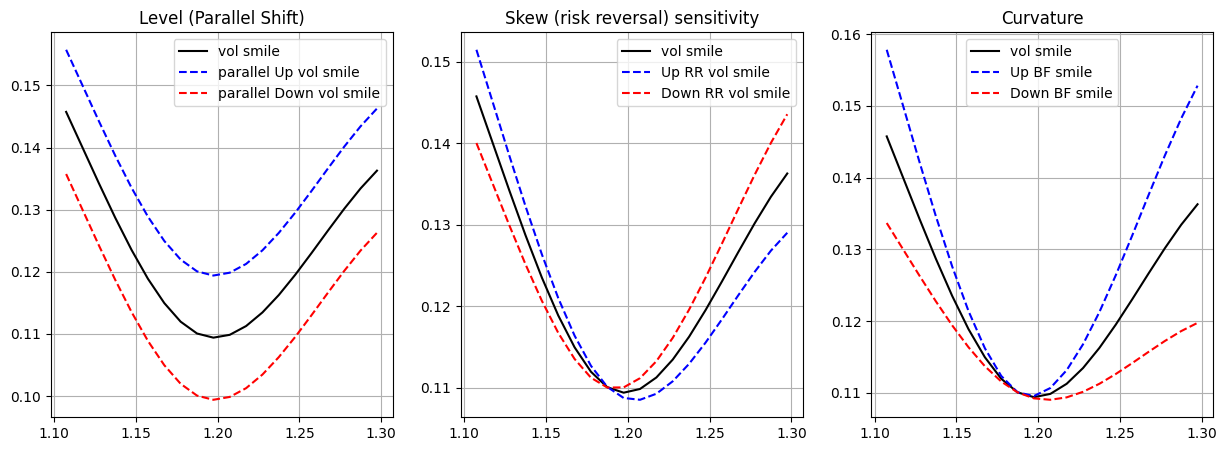

In [ ]:
c_vol = delta25_call_vol_quote.value()
p_vol = delta25_put_vol_quote.value()
a_vol = atm_vol_quote.value()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(strikes, smile_vols, 'black', label='vol smile')
delta25_call_vol_quote.setValue(c_vol + 0.01)
delta25_put_vol_quote.setValue(p_vol + 0.01)
atm_vol_quote.setValue(a_vol + 0.01)

par_vols = get_smile_vols(smile, strikes)

axs[0].plot(strikes, par_vols, 'b--', label='parallel Up vol smile')

delta25_call_vol_quote.setValue(c_vol - 0.01)
delta25_put_vol_quote.setValue(p_vol - 0.01)
atm_vol_quote.setValue(a_vol - 0.01)

par_vols = get_smile_vols(smile, strikes)

axs[0].plot(strikes, par_vols, 'r--', label='parallel Down vol smile')

delta25_call_vol_quote.setValue(c_vol)
delta25_put_vol_quote.setValue(p_vol)
atm_vol_quote.setValue(a_vol)

axs[0].set_title("Level (Parallel Shift)")
axs[0].legend()
axs[0].grid()


axs[1].plot(strikes, smile_vols, 'black', label='vol smile')
delta25_call_vol_quote.setValue(c_vol - 0.005)
delta25_put_vol_quote.setValue(p_vol + 0.005)

rr_down_vols = get_smile_vols(smile, strikes)

axs[1].plot(strikes, rr_down_vols, 'b--', label='Up RR vol smile')

delta25_call_vol_quote.setValue(c_vol + 0.005)
delta25_put_vol_quote.setValue(p_vol - 0.005)

rr_up_vols = get_smile_vols(smile, strikes)

axs[1].plot(strikes, rr_up_vols, 'r--', label='Down RR vol smile')

delta25_call_vol_quote.setValue(c_vol)
delta25_put_vol_quote.setValue(p_vol)

axs[1].set_title("Skew (risk reversal) sensitivity")
axs[1].legend()
axs[1].grid()

axs[2].plot(strikes, smile_vols, 'black', label='vol smile')

delta25_call_vol_quote.setValue(c_vol + 0.01)
delta25_put_vol_quote.setValue(p_vol + 0.01)

b_up_vols = get_smile_vols(smile, strikes)

axs[2].plot(strikes, b_up_vols, 'b--', label='Up BF smile')

delta25_call_vol_quote.setValue(c_vol - 0.01)
delta25_put_vol_quote.setValue(p_vol - 0.01)

b_down_vols = get_smile_vols(smile, strikes)

axs[2].plot(strikes, b_down_vols, 'r--', label='Down BF smile')

delta25_call_vol_quote.setValue(c_vol)
delta25_put_vol_quote.setValue(p_vol)

axs[2].set_title("Curvature")
axs[2].legend()
axs[2].grid()

plt.show()

To give you a more naive mathematical intuition, let's assume that a vol smile is represented by the following 2nd order polynomial (a very likely assumption):

$$
\sigma(x) = a + b \cdot x + c \cdot x^2, \text{ where } a, b, c \in \mathbb{R}
$$

- in the level sensitivity we are varying $a$
- when calculating the skew we are varying $b$
- while when calculating the curvature we are varying $c$

So we want to know how varying each of the function parameters effect the whole volatility smile, which in turns effected the option price.

In [ ]:
#| echo: true

delta = partial(central_diff, quote=spot_quote)
vega = partial(central_diff, quote=atm_vol_quote)
gamma = partial(central_diff_2nd, quote=spot_quote)
volga = partial(central_diff_2nd, quote=atm_vol_quote)
vanna = partial(cross_central_diff, quote_1=spot_quote, quote_2=atm_vol_quote)

## Hedging the book

As explained in the [Hedging a book of exotics options](./exotic-book.ipynb), we want to keep low exposure also to the other high order greeks, but since we don't have a single vol but smile for a specific tenor we want to hedge ourselves from the possible movements of that smile as described above. 

### Hedge methodology

Let our exposure vector be:

$$
\mathbf{E} = \begin{bmatrix} \Delta \\ \text{Level} \\ \text{Skew} \\ \text{Curvature}  \end{bmatrix}.
$$

and let our hedge matrix be:

$$
H = \left[
\begin{array}{c|cccc}
    & \text{Spot} & \text{Straddle} & \text{RR} & \text{Butterfly} \\
    \hline
    \Delta   & h_{11} & h_{12} & h_{13} & h_{14} \\
    \text{Level}   & h_{21} & h_{22} & h_{23} & h_{24} \\
    \text{Skew}  & h_{31} & h_{32} & h_{33} & h_{34} \\
    \text{Curvature}  & h_{41} & h_{42} & h_{43} & h_{44} \\
\end{array}
\right]
$$

Then we can solve the following linear system and find the weights $x$ (position sizes) just by:

$$
x = H^{-1} E
$$

In [ ]:
atm_put = put_vanilla_factory.get_option(atm_strike)
atm_call = call_vanilla_factory.get_option(atm_strike)
delta25_call = call_vanilla_factory.get_option(d25_call_strike)
delta25_put = put_vanilla_factory.get_option(d25_put_strike)

FxVanillaOptionFactory.assign_analyitcal_price_engine(atm_put, process_atm)
FxVanillaOptionFactory.assign_analyitcal_price_engine(atm_call, process_atm)
FxVanillaOptionFactory.assign_analyitcal_price_engine(delta25_call, process_25c)
FxVanillaOptionFactory.assign_analyitcal_price_engine(delta25_put, process_25p)

When we want to calculate the greeks of our portfolio, we want to do it in meaningful way, thus this requires to us to set the shift operator in a way that makes sense to measure the specific risk of our porfolio. The two main ways that industry professional do that is by using 1% of the spot change and 1% vol change.

In [ ]:
#| echo: true

spot_change = 0.01 * spot_quote.value() / 2
vol_change = 0.01
quotes = [atm_vol_quote, delta25_call_vol_quote, delta25_put_vol_quote]

delta_book = sum([pos.sensitivity(partial(central_diff, quote=spot_quote), h=spot_change) for pos in book])
level_book = sum([pos.sensitivity(partial(parallel_shift, quotes=quotes), h=vol_change) for pos in book])
skew_book = sum([pos.sensitivity(partial(skew_sensitivity, 
                                         d25_c_quote=delta25_call_vol_quote,
                                         d25_p_quote=delta25_put_vol_quote), h=vol_change) for pos in book])
curv_book = sum([pos.sensitivity(partial(curv_sensitivity, 
                                         d25_c_quote=delta25_call_vol_quote,
                                         d25_p_quote=delta25_put_vol_quote), h=vol_change) for pos in book])

The raw Greek exposition for our book is then the following:

In [ ]:
print(f"Book Delta exposure: {delta_book}")
print(f"Book Level exposure: {level_book}")
print(f"Book Skew exposure: {skew_book}")
print(f"Book Curvature Call exposure: {curv_book}")

Book Delta exposure: -115632.67827744933
Book Level exposure: 718295.615419507
Book Skew exposure: 137760.4070661429
Book Curvature Call exposure: 417234.2386220757


To get a more meaningful value of the sensitivities needed for the trader's perspective, we need to multiply the $\Delta$ by the spot value and the smile sensitivities by the $\%$ of vol that we've used to measure those sensitivities (thus in our case by $1\%$).

In [ ]:
# Trader's greeks
print(f"Book Delta exposure: ${delta_book * spot_quote.value()}")
print(f"Residual Level exposure: ${level_book * vol_change}")
print(f"Residual Skew exposure: ${skew_book * vol_change}")
print(f"Residual Curvature exposure: ${curv_book * vol_change}")

Book Delta exposure: $-136446.5603673902
Residual Level exposure: $7182.956154195071
Residual Skew exposure: $1377.6040706614292
Residual Curvature exposure: $4172.342386220757


Our exposure vector $E = [ \Delta, \text{Level}, \text{Skew}, \text{Curvature} ]$ is:

In [ ]:
#| echo: true
# Greek exposure vector
E = np.array([delta_book, level_book, skew_book, curv_book])
E

array([-115632.67827745,  718295.61541951,  137760.40706614,
        417234.23862208])

For each of the base instrument (Spot, ATM call, ATM put, $25\Delta$ call and $25\Delta$ put) let's calculate the basic greeks.

In [ ]:
#| echo: true
# hedge_matrix
base_notional = np.float64(1_000_000)
spot_greeks = np.array([1, 0, 0, 0]) * base_notional
atm_call_greeks = np.array([
    central_diff(atm_call, h=spot_change, quote=spot_quote), # Delta
    parallel_shift(atm_call, quotes, h=vol_change), # Level
    skew_sensitivity(atm_call,  # Skew
                     d25_c_quote=delta25_call_vol_quote, 
                     d25_p_quote=delta25_put_vol_quote,
                     h=vol_change),
    curv_sensitivity(atm_call, # Curvature
                     d25_c_quote=delta25_call_vol_quote, 
                     d25_p_quote=delta25_put_vol_quote,
                     h=vol_change)
]) * base_notional

atm_put_greeks = np.array([
    delta(atm_put, h=spot_change),
    parallel_shift(atm_put, quotes, h=vol_change),
    skew_sensitivity(atm_put, 
                     d25_c_quote=delta25_call_vol_quote, 
                     d25_p_quote=delta25_put_vol_quote,
                     h=vol_change),
    curv_sensitivity(atm_put, 
                     d25_c_quote=delta25_call_vol_quote, 
                     d25_p_quote=delta25_put_vol_quote,
                     h=vol_change)
]) * base_notional

delta25_call_greeks = np.array([
    delta(delta25_call, h=spot_change),
    parallel_shift(delta25_call, quotes, h=vol_change),
    skew_sensitivity(delta25_call, 
                     d25_c_quote=delta25_call_vol_quote, 
                     d25_p_quote=delta25_put_vol_quote,
                     h=vol_change),
    curv_sensitivity(delta25_call, 
                     d25_c_quote=delta25_call_vol_quote, 
                     d25_p_quote=delta25_put_vol_quote,
                     h=vol_change)
]) * base_notional

delta25_put_greeks = np.array([
    delta(delta25_put, h=spot_change),
    parallel_shift(delta25_put, quotes, h=vol_change),
    skew_sensitivity(delta25_put, 
                     d25_c_quote=delta25_call_vol_quote, 
                     d25_p_quote=delta25_put_vol_quote,
                     h=vol_change),
    curv_sensitivity(delta25_put, 
                     d25_c_quote=delta25_call_vol_quote, 
                     d25_p_quote=delta25_put_vol_quote,
                     h=vol_change)
]) * base_notional

In [ ]:
#| echo: true

# Let's create the straddle, RR, Butterfly from the base vanilla options
atm_straddle = atm_call_greeks + atm_put_greeks
rr = delta25_call_greeks - delta25_put_greeks
butterfly = delta25_call_greeks + delta25_put_greeks - 2 * atm_straddle

# Hedge Matrix
H = np.stack([spot_greeks, atm_straddle, rr, butterfly]).T

Since our system the number of equations is the same as the number of variables, thus can find the optiomal solution of the system by using `np.linalg.solve`

In [ ]:
#| echo: true
x = np.linalg.solve(H, E)

Now that we have a solution let's see what's our remaining exposure to each of the choosen hedged greeks. We do that by

$$
H x - E
$$

In [ ]:
#| echo: true
residual_greeks = (H @ x - E).tolist()

print(f"Residual Delta exposure: ${residual_greeks[0] * spot_quote.value()}")
print(f"Residual Level exposure: ${residual_greeks[1] * 0.01}")
print(f"Residual Skew exposure: ${residual_greeks[2] * 0.01}")
print(f"Residual Curvature exposure: ${residual_greeks[3] * 0.01}")

Residual Delta exposure: $0.0
Residual Level exposure: $1.1641532182693482e-12
Residual Skew exposure: $0.0
Residual Curvature exposure: $0.0


Another crucial thing when hedging a book is, of course, to measure the P&L from one rebalancing period to another. Let's then calculate the value of the various components of our hedging portfolio. We have the the P&L from time $t$ is calculated as:

$$
P\&L_{t \rightarrow t + 1} = (V_{t + 1}^{book} + V_{t + 1}^{hedge} + C_{t + 1}) - (V_{t}^{book} + V_{t}^{hedge} + C_{t})
$$

where:

- $V_{t}^{book}$ is the value of our book at time $t$, which is the sum of the premiums that we've been collected
- $V_{t}^{hedge}$ is the value of the hedging portfolio, the sum of the premium of the structures that we have bought to hedge our from the various sensistivies
- $C_t$ the cash/bank account of our portfolio which includes financing of cash and trade cashflows

A shorter way to express the P&L, is just by considering the variation of the value of the book + the variation of the value of the hedges + cost of borrowing + interest accrued:

$$
P\&L_{t \rightarrow t + 1} = \delta V_{t, t + 1}^{book} + \delta V_{t, t + 1}^{hedge} + \text{cost of borrowing} + \text{interest accrued}
$$

since the rebalancing of the hedges of the bank account happend at the end of trading day.

In [ ]:
#| echo: true
spot_premium_eur = x[0] * base_notional
spot_premium_usd = x[0] * base_notional * spot_quote.value()
atm_straddle_premium = atm_call.NPV() + atm_put.NPV() * base_notional * x[1]
rr_premium = delta25_call.NPV() - delta25_put.NPV() * base_notional * x[2]
butterfly_premium = (delta25_call.NPV() + delta25_put.NPV() - 2 * (atm_call.NPV() + atm_put.NPV())) * x[3] * base_notional

The usd borrowed (which is the sum of the premiums of or hedging instrument) is crucial for use to calculate the interest accrued for borrowing the usd dollars to buy the hedging structures.

In [ ]:
#| echo: true
hedging_str_premium = atm_straddle_premium + rr_premium + butterfly_premium + spot_premium_usd
hedging_str_premium

np.float64(-543905.6415990698)

Thus the value of the cash at time $t = 0$ is the equal to all the cash that we've borrowed to build the hedging structures plus the premiums that we've been collected from selling the exotics options

In [ ]:
#| echo: true
bank_account_value = - hedging_str_premium + np.sum(premiums)
bank_account_value

np.float64(610070.8591107951)

In [ ]:
#| echo: true
port_value = [hedging_str_premium - np.sum(premiums) + bank_account_value]

print(f"The portfolio value at time t = 0 is {port_value[0]}")

The portfolio value at time t = 0 is 0.0


## Changes of the hedging portfolio with the changes of the market conditions

Now that we have setup our hedging portfolio, let's verify how it will change as the spot and vol smile change. Let's assume that in a week period the spot went go down by 300 pips, the ATM vol went up by $0.5\%$ while the the 25 $\Delta$ Put vol went up $0.8\%$ (since the price to hedge from downside has went up because of the underlying so there is more demand for puts). 

In [ ]:
#| echo: true
ref_date = today + ql.Period(7, ql.Days)
expiration_time = dc.yearFraction(ref_date, expiration_date)
exp_time_quote.setValue(expiration_time)

spot_quote.setValue(1.15)
atm_vol_quote.setValue(atm_vol + 0.005)
delta25_put_vol_quote.setValue(delta25_put_vol + 0.008)

new_d25_call_strike = delta_call_calc.strikeFromDelta(0.25)
new_d25_put_strike = delta_put_calc.strikeFromDelta(-0.25)
new_atm_strike = delta_call_calc.atmStrike(ql.DeltaVolQuote.AtmDeltaNeutral)

new_smile = ql.SplineCubicInterpolatedSmileSection(
    expiration_time, 
    [new_d25_put_strike, new_atm_strike, new_d25_call_strike],
    [delta25_p_std_handle, atm_std_handle, delta25_c_std_handle],
    atm_vol_handle
)

# Move vols and expiry time
ql.Settings.instance().evaluationDate = ref_date

Here's how the new smile looks like compared to the old the smile: 

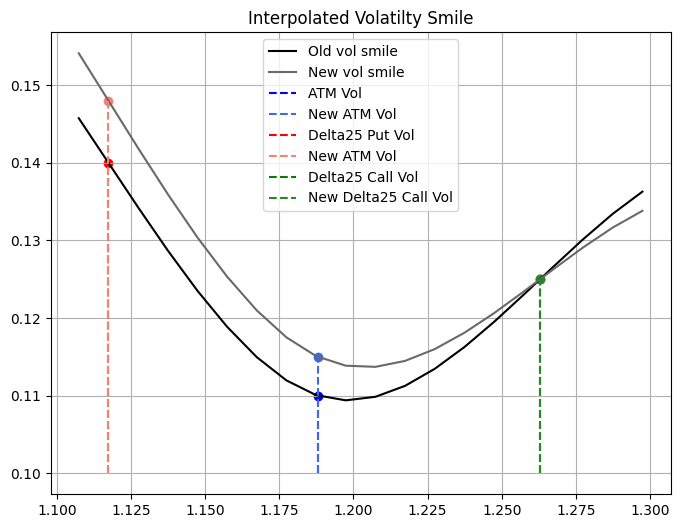

In [ ]:
ax, fig = plt.subplots(1, 1, figsize=(8, 6))
new_smile_vol = get_smile_vols(new_smile, strikes)

plt.plot(strikes, smile_vols, 'black', label='Old vol smile')
plt.plot(strikes, new_smile_vol, 'dimgray', label='New vol smile')

plt.vlines(atm_strike, 0.10, atm_vol, color='blue', linestyle='--', label='ATM Vol')
plt.scatter(atm_strike, atm_vol, color='blue', marker='o') # Mark the point
plt.vlines(new_atm_strike, 0.10, atm_vol_quote.value(), color='royalblue', linestyle='--', label='New ATM Vol')
plt.scatter(new_atm_strike, atm_vol_quote.value(), color='royalblue', marker='o')

plt.vlines(d25_put_strike, 0.10, delta25_put_vol, color='red', linestyle='--', label='Delta25 Put Vol')
plt.scatter(d25_put_strike, delta25_put_vol, color='red', marker='o')
plt.vlines(new_d25_put_strike, 0.10, delta25_put_vol_quote.value(), color='salmon', linestyle='--', label='New ATM Vol')
plt.scatter(new_d25_put_strike, delta25_put_vol_quote.value(), color='salmon', marker='o')

plt.vlines(d25_call_strike, 0.10, delta25_call_vol, color='green', linestyle='--', label='Delta25 Call Vol')
plt.scatter(d25_call_strike, delta25_call_vol, color='green', marker='o') # Mark the point
plt.vlines(new_d25_call_strike, 0.10, delta25_call_vol_quote.value(), color='forestgreen', linestyle='--', label='New Delta25 Call Vol')
plt.scatter(new_d25_call_strike, delta25_call_vol_quote.value(), color='forestgreen', marker='o') # Mark the point

plt.title('Interpolated Volatilty Smile')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#| echo: true
new_premiums = [pos.NPV() for pos in book]

With the new spot and vols let's recalculate the book exposure

In [ ]:
#| echo: true
delta_book = sum([pos.sensitivity(partial(central_diff, quote=spot_quote), h=spot_change) for pos in book])
level_book = sum([pos.sensitivity(partial(parallel_shift, quotes=quotes), h=vol_change) for pos in book])
skew_book = sum([pos.sensitivity(partial(skew_sensitivity, 
                                         d25_c_quote=delta25_call_vol_quote,
                                         d25_p_quote=delta25_put_vol_quote), h=vol_change) for pos in book])
curv_book = sum([pos.sensitivity(partial(curv_sensitivity, 
                                         d25_c_quote=delta25_call_vol_quote,
                                         d25_p_quote=delta25_put_vol_quote), h=vol_change) for pos in book])

# new Exposure vector
E = np.array([delta_book, level_book, skew_book, curv_book])

In [ ]:
print(f"Book Delta exposure: ${delta_book * spot_quote.value()}")
print(f"Residual Level exposure: ${level_book * vol_change}")
print(f"Residual Skew exposure: ${skew_book * vol_change}")
print(f"Residual Curvature exposure: ${curv_book * vol_change}")

Book Delta exposure: $-426252.06994998624
Residual Level exposure: $6494.259093454982
Residual Skew exposure: $1365.6531019809127
Residual Curvature exposure: $5016.983190482754


As before let's recalculate the greeks for the basic trading instruments, and then combine to obtain the greeks for the structures used in the hedging portfolio.

In [ ]:
#| echo: true
# hedge_matrix
base_notional = np.float64(1_000_000)
spot_greeks = np.array([1, 0, 0, 0]) * base_notional
atm_call_greeks = np.array([
    central_diff(atm_call, h=spot_change, quote=spot_quote), # Delta
    parallel_shift(atm_call, quotes, h=vol_change), # Level
    skew_sensitivity(atm_call,  # Skew
                     d25_c_quote=delta25_call_vol_quote, 
                     d25_p_quote=delta25_put_vol_quote,
                     h=vol_change),
    curv_sensitivity(atm_call, # Curvature
                     d25_c_quote=delta25_call_vol_quote, 
                     d25_p_quote=delta25_put_vol_quote,
                     h=vol_change)
]) * base_notional

atm_put_greeks = np.array([
    delta(atm_put, h=spot_change),
    parallel_shift(atm_put, quotes, h=vol_change),
    skew_sensitivity(atm_put, 
                     d25_c_quote=delta25_call_vol_quote, 
                     d25_p_quote=delta25_put_vol_quote,
                     h=vol_change),
    curv_sensitivity(atm_put, 
                     d25_c_quote=delta25_call_vol_quote, 
                     d25_p_quote=delta25_put_vol_quote,
                     h=vol_change)
]) * base_notional

delta25_call_greeks = np.array([
    delta(delta25_call, h=spot_change),
    parallel_shift(delta25_call, quotes, h=vol_change),
    skew_sensitivity(delta25_call, 
                     d25_c_quote=delta25_call_vol_quote, 
                     d25_p_quote=delta25_put_vol_quote,
                     h=vol_change),
    curv_sensitivity(delta25_call, 
                     d25_c_quote=delta25_call_vol_quote, 
                     d25_p_quote=delta25_put_vol_quote,
                     h=vol_change)
]) * base_notional

delta25_put_greeks = np.array([
    delta(delta25_put, h=spot_change),
    parallel_shift(delta25_put, quotes, h=vol_change),
    skew_sensitivity(delta25_put, 
                     d25_c_quote=delta25_call_vol_quote, 
                     d25_p_quote=delta25_put_vol_quote,
                     h=vol_change),
    curv_sensitivity(delta25_put, 
                     d25_c_quote=delta25_call_vol_quote, 
                     d25_p_quote=delta25_put_vol_quote,
                     h=vol_change)
]) * base_notional

In [ ]:
#| echo: true
# Let's create the straddle, RR, Butterfly from the base vanilla options
atm_straddle = atm_call_greeks + atm_put_greeks
rr = delta25_call_greeks - delta25_put_greeks
butterfly = delta25_call_greeks + delta25_put_greeks - 2 * atm_straddle

# Hedge Matrix
H = np.stack([spot_greeks, atm_straddle, rr, butterfly]).T

The esposure of our hedging portfolio is now is:

In [ ]:
#| echo: true
# New exposure of the hedging portfolio
exposure = (H @ x - E).tolist()

print(f"Residual Delta exposure: ${exposure[0] * spot_quote.value()}")
print(f"Residual Level exposure: ${exposure[1] * 0.01}")
print(f"Residual Skew exposure: ${exposure[2] * 0.01}")
print(f"Residual Curvature exposure: ${exposure[3] * 0.01 * spot_quote.value()}")

Residual Delta exposure: $2738.4458590258755
Residual Level exposure: $-67.84857193228905
Residual Skew exposure: $-411.47083519745325
Residual Curvature exposure: $-1701.7232883233276


To calculate the $\text{P\&L}$ from time $t$ to $t+1$ we need to calculate the change of the value of the hedging portfolio as well

In [ ]:
#| echo: true
spot_premium_usd = x[0] * base_notional * spot_quote.value()
atm_straddle_premium = atm_call.NPV() + atm_put.NPV() * base_notional * x[1]
rr_premium = delta25_call.NPV() - delta25_put.NPV() * base_notional * x[2]
butterfly_premium = (delta25_call.NPV() + delta25_put.NPV() - 2 * (atm_call.NPV() + atm_put.NPV())) * x[3] * base_notional
new_hedging_str_premium = atm_straddle_premium + rr_premium + butterfly_premium + spot_premium_usd

In [ ]:
#| echo: true
dt = dc.yearFraction(today, today + ql.Period(7, ql.Days))
usd_interest_cost = hedging_str_premium * r_d * dt
eur_interest_accr = spot_premium_eur * r_f * dt
new_total_portfolio_value = new_hedging_str_premium - np.sum(new_premiums) + bank_account_value - usd_interest_cost + eur_interest_accr * spot_quote.value()

print(f"Portfolio value at time t = 1 is: ${new_total_portfolio_value}")

Portfolio value at time t = 1 is: $30021.90322561409


In [ ]:
port_value.append(new_total_portfolio_value)

In [ ]:
print(f"The P&L after a week is: ${port_value[1] - port_value[0]}")

The P&L after a week is: $30021.90322561409


If we want to reduce our exposure and bring it back to a lower one, we need to recalculate the optimal hedging weights for our hedging portfolio as before:

In [ ]:
#| echo: true
x_new = np.linalg.solve(H, E)

This how our hedging portfolio has to change: 

In [ ]:
#| echo: true
(x_new - x) * base_notional

array([-101803.29731514,  418687.61215821,  208353.40317859,
        322112.47789261])

The residual greek exposure after the rebalancing is: 

In [ ]:
new_residual_greeks_exp = (H @ x_new - E).tolist()

print(f"Residual Delta exposure: ${new_residual_greeks_exp[0] * spot_quote.value()}")
print(f"Residual Level exposure: ${new_residual_greeks_exp[1] * vol_change}")
print(f"Residual Skew exposure: ${new_residual_greeks_exp[2] * vol_change}")
print(f"Residual Curvature exposure: ${new_residual_greeks_exp[3] * vol_change}")

Residual Delta exposure: $1.3387762010097503e-10
Residual Level exposure: $0.0
Residual Skew exposure: $0.0
Residual Curvature exposure: $0.0
